# Demonstration

### Precision of MaNGA cube reconstruction from reduced spectra

In this demo, a sample MaNGA RSS file is taken from Data Release 17. RealSim-IFS is used to spatially reconstruct flux and variance cubes from the fibre data (and positions).

In [1]:
import os,sys,time,copy
import numpy as np
from astropy.io import fits
from realsim_ifs import ifs as rifs
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
import warnings
warnings.filterwarnings("ignore")
wdir = os.getcwd() # change to working directory


### Get RSS data and cube from SDSS Science Archive Server (SAS)

First, download the data locally. [Marvin](https://www.sdss.org/dr17/manga/manga-tutorials/how-do-i-look-at-my-data/marvin) is also a great tool for accessing MaNGA data and is recommended for more interactive usage. Here, we will simply download the files to the current workspace. The code block below downloads the linearly spaced RSS and CUBE file for plate-ifu target 7443-12703 as used in the RealSim-IFS paper. It can take around 10 mins for each file to be downloaded.

In [2]:
sas_base_dir = 'https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/'

plate = 7443
ifudesign = 12703

cubename = f'manga-{plate}-{ifudesign}-LINCUBE.fits'
rssname = f'manga-{plate}-{ifudesign}-LINRSS.fits'


if not os.access(rssname,0):
    
    target_url = f'{sas_base_dir}/{plate}/stack/{rssname}.gz'
    wget_cmd = f'wget -O {wdir}/{rssname} {target_url}'
    start = time.time()
    os.system(wget_cmd)
    os.system(f'gunzip -f {rssname}.gz')
    print(time.time()-start)
    
if not os.access(cubename,0):
        
    target_url = f'{sas_base_dir}/{plate}/stack/{cubename}.gz'
    wget_cmd = f'wget -O {wdir}/{cubename} {target_url}'
    start = time.time()
    os.system(wget_cmd)
    os.system(f'gunzip -f {cubename}.gz')
    print(time.time()-start)
    

### Extract reconstruction data from RSS file

Next, we extract the information from the RSS files needed for the cube construction. The variance spectra are needed to mask bad data but can also optionally be reconstructed into cubes alongside the fluxes. This part differs somewhat from an application of RealSim-IFS to simulated data, where effects such as differential atmospheric refraction and IFU manufacture uncertainties yield wavelength-dependent fiber core positions which do not perfectly align with the idealized design. However, the true wavelength-dependent positions of the fibres have been measured precisely and can be accounted for in the reconstruction by reconstructing slice-by-slice in each wavelength element. Note the shape of `xpos` below is (1905,6732). Each of the 1905 fibres' positions are measured for all 6732 MaNGA wavelength channels. These positions are in arcsec and the center of the IFU design is located at (0,0).

In [3]:
with fits.open(rssname) as hdul:
    rss_flux = hdul['FLUX'].data
    lam = hdul['WAVE'].data
    xpos = hdul['XPOS'].data
    ypos = hdul['YPOS'].data
    rss_ivar = hdul['IVAR'].data
print(xpos.shape)

(1905, 6732)


Next, mask the RSS data for which the inverse variance is zero to remove these from the spatial reconstruction calculations.

In [4]:
rss_flux[rss_ivar==0.]=np.nan
rss_ivar[rss_ivar==0.]=np.nan

### Reconstruct cubes channel-by-channel

We will reconstruct the flux and variance cubes for just 3 wavelength element slices. RealSim-IFS supports wavelength-dependent fiber positions. But this must be handled with a wrapper for RealSim-IFS with the spatial reconstruction being performed slice-by-slice as shown below. Otherwise, RealSim-IFS assumes that the fiber positions are the same for all wavelength channels. Element-by-element operations are not particularly fast. A full MaNGA cube may take ~30 minutes. For the purposes of this demo, 3 slices are used.

In [5]:
# wavelength channels to reconstruct
idxs = [0,2500,5000]

output_grid_dims_arcsec = 37 
out_arcsec_per_pixel = 0.5
output_grid_dims = int(output_grid_dims_arcsec/out_arcsec_per_pixel)
diam_cores_arcsec = 2. 

cube_flux = np.zeros((len(idxs),output_grid_dims,output_grid_dims))
cube_ivar = np.zeros_like(cube_flux)


for i,lam_index in enumerate(idxs):

    # coordinate change to convert to pixel
    core_x_pixels = (xpos[:,lam_index]/out_arcsec_per_pixel+output_grid_dims/2).flatten()+0.5
    core_y_pixels = (ypos[:,lam_index]/out_arcsec_per_pixel+output_grid_dims/2).flatten()+0.5
    core_diameter_pixels = diam_cores_arcsec/out_arcsec_per_pixel 

    import time
    start = time.time()
    out_slice,weight_map = rifs.ifu_to_grid(rss_flux[:,lam_index].reshape(-1,1),
                                            core_x_pixels,core_y_pixels,core_diameter_pixels,
                                            grid_dimensions_pixels=output_grid_dims,
                                            use_gaussian_weights=True,
                                            gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                            rlim_pixels=1.6/out_arcsec_per_pixel,
                                            use_broadcasting=False,
                                            ivar_data=rss_ivar[:,lam_index].reshape(-1,1))
    
    slice_flux,slice_ivar = out_slice
    cube_flux[i] = slice_flux[0]
    cube_ivar[i] = slice_ivar[0]
    print(time.time()-start)
    

rifs_flux_file = f'{wdir}/Precision_FLUX_Slices.npy'
rifs_ivar_file = f'{wdir}/Precision_IVAR_Slices.npy'
np.save(rifs_flux_file,cube_flux)
np.save(rifs_ivar_file,cube_ivar)

0.5536890029907227
0.4078490734100342
0.3725471496582031


### Compare reconstructed and DRP flux cube slices

The following code cell is almost entirely plotting and no new operations on the data are made. The figure shows the RealSim-IFS reconstructed wavelength elements of the cube for 3 wavelength channels, the true MaNGA LINCUBE data in the same channels, and the log-offset of the two reconstructions. The log-offsets show that the results are identical.

1.7170731891891222e-08
1.7654958384127895e-08
1.8575572080514746e-08


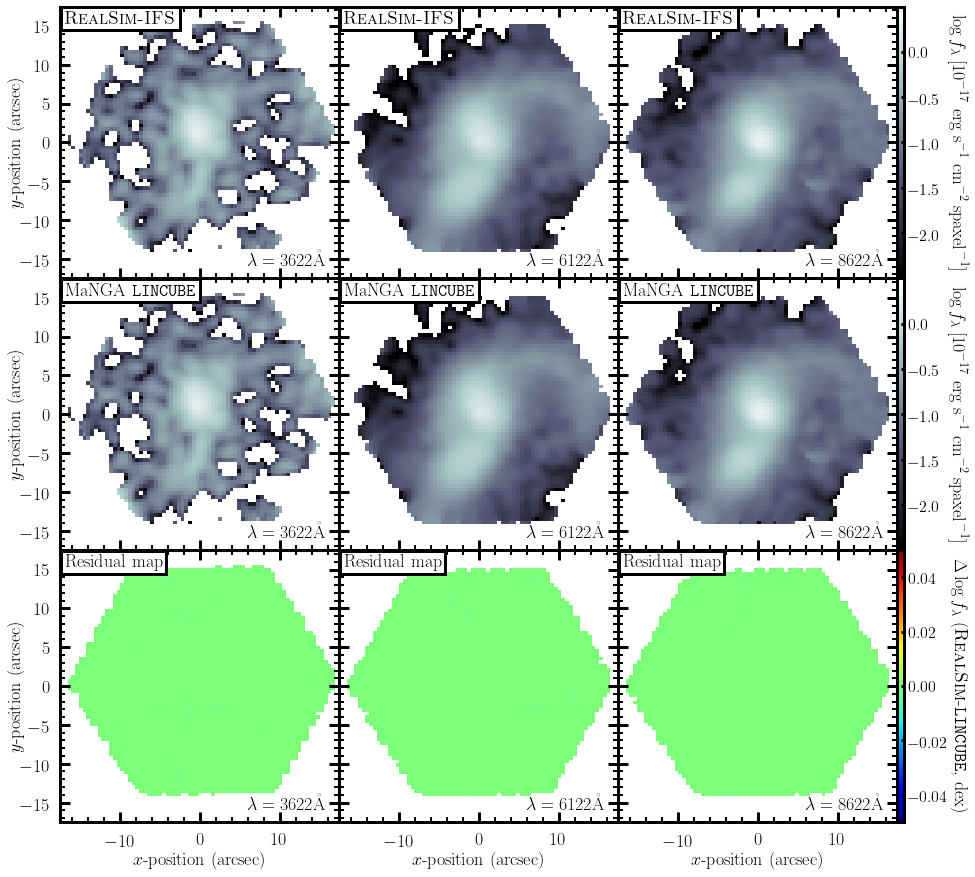

In [6]:
from matplotlib import cm
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

def add_colorbar(im,ax,label,colour='white',dropticks=True):
    axin = ax.inset_axes(
            [1.,0., 0.025, 1.], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='vertical')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=0,
                        labelbottom=0,labelleft=0,labelright=1,top=0,bottom=0,right=1,left=0,
                        width=3, labelsize=16, labelrotation=0)
    
    if dropticks:
        plt.setp(axin.get_yticklabels()[0], visible=False)  
        plt.setp(axin.get_yticklabels()[-1], visible=False)  
    
    cbar.set_label(label,color=colour,size=18,rotation=270,labelpad=20)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(3)
    return cbar

fig,axarr = plt.subplots(3,3,figsize=(15,15))
fig.subplots_adjust(wspace=0.0,hspace=0.0)

axarr = axarr.flatten()

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0,labelbottom=0)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)
    
for ax in axarr[6:]:
    ax.tick_params(axis='both',which='major',labelbottom=1)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)
    
for ax in axarr[[0,3,6]]:
    ax.tick_params(axis='both',which='major',labelleft=1)
    ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18,labelpad=-5)
    
for ax in axarr.flat[-2:]:
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0)
    
axarr = axarr.reshape(3,3)
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

idxs = np.array([0,2500,5000])

flux_rifs = np.load(rifs_flux_file)
    
with fits.open(f'{wdir}/{cubename}','readonly') as hdul:
    
    flux = hdul['flux'].data
    
for i,idx in enumerate(idxs):
    
    ax = axarr[0,i]
    im = ax.imshow(np.log10(flux_rifs[i]),cmap='bone',origin='lower',vmin=-2.5,vmax=0.5,
              extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        label = r'$\log f_{\lambda}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
        cbar = add_colorbar(im,ax,label,colour='black',dropticks=True)
        cbar.ax.yaxis.labelpad = 27.5
    
    ax = axarr[1,i]
    im = ax.imshow(np.log10(flux[idx]),cmap='bone',origin='lower',vmin=-2.5,vmax=0.5,
                   extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        cbar = add_colorbar(im,ax,label,colour='black',dropticks=True)
        cbar.ax.yaxis.labelpad = 27.5
        
    ax = axarr[2,i]
    im = ax.imshow(np.log10(flux_rifs[i]/flux[idx]),cmap='jet',origin='lower',vmin=-0.05,vmax=0.05,
              extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        label = r'$\Delta \log f_{\lambda}$ (\textsc{RealSim}-\texttt{LINCUBE}, dex)'
        add_colorbar(im,ax,label,colour='black',dropticks=False)

print(np.nanmedian(np.log10(flux_rifs[0])-np.log10(flux[idxs[0]])))
print(np.nanmedian(np.log10(flux_rifs[1])-np.log10(flux[idxs[1]])))
print(np.nanmedian(np.log10(flux_rifs[2])-np.log10(flux[idxs[2]])))
fig.savefig('cube_slice_comparison.pdf',bbox_inches='tight')

### Compare reconstructed and DRP variance cube slices

Similar to the last figure but showing the reconstructed variance cubes. Again, the results are identical.

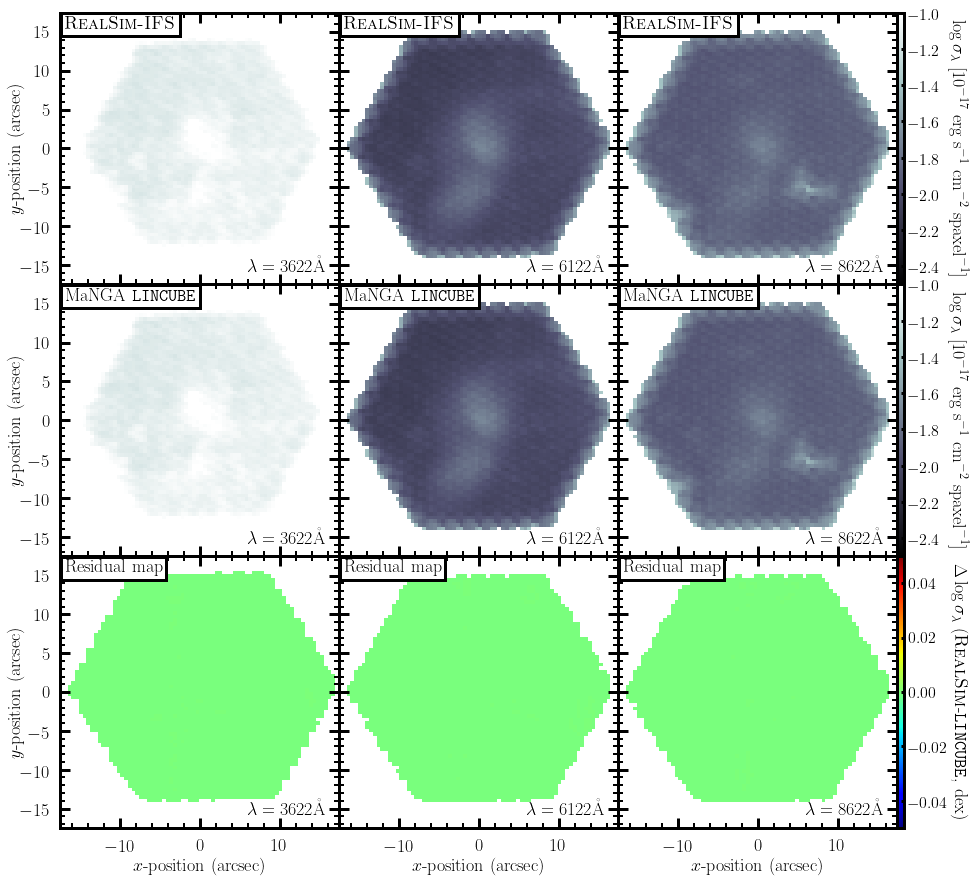

In [7]:
fig,axarr = plt.subplots(3,3,figsize=(15,15))
fig.subplots_adjust(wspace=0.0,hspace=0.0)

axarr = axarr.flatten()

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0,labelbottom=0)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)
    
for ax in axarr[6:]:
    ax.tick_params(axis='both',which='major',labelbottom=1)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)
    
for ax in axarr[[0,3,6]]:
    ax.tick_params(axis='both',which='major',labelleft=1)
    ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18,labelpad=-5)
    
for ax in axarr.flat[-2:]:
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0)
    
axarr = axarr.reshape(3,3)
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

idxs = np.array([0,2500,5000])

ivar_rifs = np.load(rifs_ivar_file)
    
with fits.open(f'{wdir}/{cubename}','readonly') as hdul:
    
    ivar = hdul['ivar'].data
    
for i,idx, in enumerate(idxs):
    
    ax = axarr[0,i]
    im = ax.imshow(-np.log10(np.sqrt(ivar_rifs[i])),cmap='bone',origin='lower',vmin=-2.5,vmax=-1,
              extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        label = r'$\log \sigma_{\lambda}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
        cbar = add_colorbar(im,ax,label,colour='black',dropticks=False)
        cbar.ax.yaxis.labelpad = 27.5
    
    ax = axarr[1,i]
    im = ax.imshow(-np.log10(np.sqrt(ivar[idx])),cmap='bone',origin='lower',vmin=-2.5,vmax=-1,
                   extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        cbar = add_colorbar(im,ax,label,colour='black',dropticks=False)
        cbar.ax.yaxis.labelpad = 27.5
        
    ax = axarr[2,i]
    im = ax.imshow(np.log10(np.sqrt(ivar_rifs[i]/ivar[idx])),cmap='jet',origin='lower',vmin=-0.05,vmax=0.05,
              extent=(-17.5,17.5,-17.5,17.5),aspect='auto',interpolation='None')
    ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
    ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[idx]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
    if i==2:
        label = r'$\Delta \log\sigma_{\lambda}$ (\textsc{RealSim}-\texttt{LINCUBE}, dex)'
        add_colorbar(im,ax,label,colour='black',dropticks=False)
        
fig.savefig('variance_slice_comparison.pdf',bbox_inches='tight')